# Стохастический градиентный и координатный спуски

Для каждого задания указано количество баллов (если они оцениваются отдельно) + 1 балл за аккуратное и полное выполнение всего задания

In [66]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

## Загрузка и подготовка данных

**Загрузите уже знакомый вам файл *Advertising.csv* как объект DataFrame.** 

In [67]:
data = pd.read_csv('data/Advertising.csv', sep=',')

**Проверьте, есть ли в данных пропуски и, если они есть - удалите их**

In [68]:
data.isna().sum()

Unnamed: 0    0
TV            0
radio         0
newspaper     0
sales         0
dtype: int64

**Преобразуйте ваши признаки в массивы NumPy и разделите их на переменные X (предикторы) и y(целевая переменная)** 

In [69]:
X = data.drop(['Unnamed: 0', 'sales'], axis=1)
y = data['sales']
n = len(y)
X = X.values.reshape(n,3)
y = data['sales'].values.reshape(n, 1) # Приводим в необходимый вид вектор

## Координатный спуск (3 балла)

**Добавим единичный столбец для того, чтобы у нас был свободный коэффициент в уравнении регрессии:**

In [70]:
X_with_one = np.append(np.ones((n,1)), X, axis = 1) # Приводим в необходимый вид матрицу

**Нормализуем данные: обычно это необходимо для корректной работы алгоритма**

In [71]:
X_norm = X_with_one / np.sqrt(np.sum(np.square(X_with_one), axis=0))

**Реализуйте алгоритм координатного спуска:** (3 балла)

Ниже приведен алгоритм:

<a href="https://ibb.co/Th3BQFn"><img src="https://i.ibb.co/DK2DBS6/zascas.jpg" alt="zascas" border="0"></a>

Примечание: 1000 итераций здесь указаны для этого задания, на самом деле их может быть намного больше, нет детерменированного значения.

Вам необходимо реализовать координатный спуск, и вывести веса в модели линейной регрессии.

In [72]:
# Нулевой вектор весов
w = np.zeros((X_norm.shape[1], 1))

# Алгоритм координатного спуска
for i in range(1000):
    r = y - X_norm.dot(w)
    for j in range(len(w)):
        A = X_norm[:, j]*w[j]
        A = np.expand_dims(A, 1)
        r = r + A
        w[j] = X_norm[:, j].dot(r)
        A = X_norm[:, j]*w[j]
        A = np.expand_dims(A, 1)
        r = r - A

coef = w.tolist()

print(f'Веса модели линейной регрессии: {coef}')

Веса модели линейной регрессии: [[41.562172046036096], [110.13144155326064], [73.52860637603482], [-0.5500638414307225]]


Сравните результаты с реализацией линейной регрессии из библиотеки sklearn:

In [73]:
from sklearn.linear_model import LinearRegression
 
model = LinearRegression(fit_intercept=False)
model.fit(X_norm, y)
 
print(model.coef_)

[[ 41.56217205 110.13144155  73.52860638  -0.55006384]]


Если вы все сделали верно, они должны практически совпасть!

## Стохастический градиентный спуск (6 баллов)

**Отмасштабируйте столбцы исходной матрицы *X* (которую мы не нормализовали еще!). Для того, чтобы это сделать, надо вычесть из каждого значения среднее и разделить на стандартное отклонение** (0.5 баллов)

In [74]:
X = data.drop(['Unnamed: 0', 'sales'], axis=1).values.reshape(n,3)
X_scaled = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

**Добавим единичный столбец**

In [75]:
X_scaled_2 = np.hstack([np.ones(X_scaled.shape[0]).reshape(-1, 1), X_scaled])

**Создайте функцию mse_error для вычисления среднеквадратичной ошибки, принимающую два аргумента: реальные значения и предсказывающие, и возвращающую значение mse** (0.5 балла)

In [76]:
def mse_error(arg_real, arg_pred):
    """Функция для вычисления среднеквадратической ошибки"""
    return np.square(np.subtract(arg_real, arg_pred)).mean()

**Сделайте наивный прогноз: предскажите продажи средним значением. После этого рассчитайте среднеквадратичную ошибку для этого прогноза** (0.5 балла)

In [77]:
y_pred_mean = np.full(len(y), y.mean())
print(f'Среднеквадратичная ошибка при наивном прогнозе по среднему значению: {mse_error(y, y_pred_mean)}')

Среднеквадратичная ошибка при наивном прогнозе по среднему значению: 27.08574375


**Создайте функцию *lin_pred*, которая может по матрице предикторов *X* и вектору весов линейной модели *w* получить вектор прогнозов** (0.5 балла)

In [78]:
def lin_pred(X, w):
    """Функция для получения вектора прогнозов"""
    return np.dot(X, w)

**Создайте функцию *stoch_grad_step* для реализации шага стохастического градиентного спуска. (1.5 балла) 
Функция должна принимать на вход следующие аргументы:**
* матрицу *X*
* вектора *y* и *w*
* число *train_ind* - индекс объекта обучающей выборки (строки матрицы *X*), по которому считается изменение весов
* число *$\eta$* (eta) - шаг градиентного спуска

Результатом будет вектор обновленных весов

Шаг для стохастического градиентного спуска выглядит следующим образом:

$$\Large w_j \leftarrow w_j - \frac{2\eta}{\ell} \sum_{i=1}^\ell{{x_{ij}((w_0 + w_1x_{i1} + w_2x_{i2} +  w_3x_{i3}) - y_i)}}$$

Для того, чтобы написать функцию, нужно сделать следующее:
    
*  посчитать направление изменения: умножить объект обучающей выборки на 2 и на разницу между предсказанным значением и реальным, а потом поделить на количество элементов в выборке.
* вернуть разницу между вектором весов и направлением изменения, умноженным на шаг градиентного спуска

In [79]:
def stoch_grad_step(X, y, w, train_ind, eta):
    """Функция, реализующая шаг стохастического градиентного спуска"""
    l = len(y)
    grad0 = (np.dot(X[train_ind],w)-y[train_ind])*2*X[train_ind,0]
    grad1 = (np.dot(X[train_ind],w)-y[train_ind])*2*X[train_ind,1]
    grad2 = (np.dot(X[train_ind],w)-y[train_ind])*2*X[train_ind,2]
    grad3 = (np.dot(X[train_ind],w)-y[train_ind])*2*X[train_ind,3]
    return (w - eta / l * np.array([grad0, grad1, grad2, grad3]))

**Создайте функцию *stochastic_gradient_descent*, для реализации стохастического градиентного спуска (2.5 балла)**

**Функция принимает на вход следующие аргументы:**
- Матрицу признаков X
- Целевую переменнную
- Изначальную точку (веса модели)
- Параметр, определяющий темп обучения
- Максимальное число итераций
- Евклидово расстояние между векторами весов на соседних итерациях градиентного спуска,при котором алгоритм прекращает работу 

**На каждой итерации в вектор (список) должно записываться текущее значение среднеквадратичной ошибки. Функция должна возвращать вектор весов $w$, а также вектор (список) ошибок.**

Алгоритм сследующий:
    
* Инициализируйте расстояние между векторами весов на соседних итерациях большим числом (можно бесконечностью)
* Создайте пустой список для фиксации ошибок
* Создайте счетчик итераций
* Реализуйте оновной цикл обучения пока расстояние между векторами весов больше того, при котором надо прекратить работу (когда расстояния станут слишком маленькими - значит, мы застряли в одном месте) и количество итераций меньше максимально разрешенного: сгенерируйте случайный индекс, запишите текущую ошибку в вектор ошибок, запишите в переменную текущий шаг стохастического спуска с использованием функции, написанной ранее. Далее рассчитайте текущее расстояние между векторами весов и прибавьте к счетчику итераций 1.
* Верните вектор весов и вектор ошибок

In [80]:
errors = [] #список ошибок MSE
w_list = [] #список векторов весов
iter_list = [] #список номеров итераций

def stochastic_gradient_descent(X,y,w0,eta,max_iteration,euclid_dist):
    """Функция, реализующая алгоритм стохастического градиентного спуска"""
    dist = 1000000
    w = np.array(w0)
    iter_counter = 0
    
    while (dist> euclid_dist) and (iter_counter<max_iteration):
        random_index = np.random.randint(X.shape[0])
        w_new = stoch_grad_step(X,y,w,random_index,eta)
        dist = np.linalg.norm(w_new-w)
        errors.append(mse_error(y,lin_pred(X,w_new)))
        w_list.append(w_new)
        iter_counter += 1
        iter_list.append(iter_counter)
        w = w_new
    return w,errors

 **Запустите $10^5$ итераций стохастического градиентного спуска. Укажите вектор начальных весов, состоящий из нулей. Можете поэкспериментировать с параметром, отвечающим за темп обучения.**

**Постройте график зависимости ошибки от номера итерации**

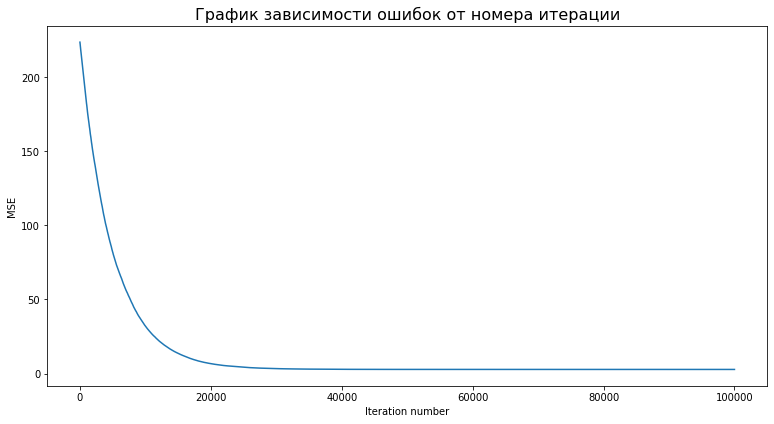

In [81]:
w, erros_list = stochastic_gradient_descent(X=X_scaled_2, y=y, w0=np.zeros(4), eta=1e-2, max_iteration=1e5, euclid_dist=1e-10)

fig = plt.figure(figsize=(10,5))
axes = fig.add_axes([0, 0, 1, 1])
axes.plot(erros_list)
axes.set_title('График зависимости ошибок от номера итерации', fontsize=16)
axes.set_xlabel('Iteration number')
axes.set_ylabel('MSE');

**Выведите вектор весов, к которому сошелся метод.**

In [82]:
print(f'Вектор весов, к которому сошелся метод: {w}')

Вектор весов, к которому сошелся метод: [[14.03028564 14.03028564 14.03028564 14.03028564]
 [ 3.93413184  3.93413184  3.93413184  3.93413184]
 [ 2.78103805  2.78103805  2.78103805  2.78103805]
 [-0.01525298 -0.01525298 -0.01525298 -0.01525298]]


**Выведите среднеквадратичную ошибку на последней итерации.**

In [84]:
print(f'Среднеквадратическая ошибка на последней итерации для алгоритма стохастического градиентного спуска: {mse_error(y, lin_pred(X_scaled_2, w))}')
print(f'Среднеквадратическая ошибка на последней итерации для алгоритма координатного спуска: {mse_error(y, lin_pred(X_norm, coef))}')

Среднеквадратическая ошибка на последней итерации для алгоритма стохастического градиентного спуска: 2.7845203315673306
Среднеквадратическая ошибка на последней итерации для алгоритма координатного спуска: 2.7841263145109365


**Вывод:**

Разница между алгоритмами стохастического градиетного спуска и координатного спуска по показателю MSE оказалась минимальна (в 4 знаке после запятой). При выборе какой из данных алгоритмов использовать необходимо понимать используемую функцию потерь (ее показатели выпуклости, замкнутости).